## #5: Stimulus decoding - Luke Longren

Time to complete the excercise: ~9 hrs, started off well but got muddled with some errors towards the end.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import mlab
from estimate_decoder import estimate_decoder  # the provided .py file

In [2]:
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')
plt.rcParams.update({'font.size': 12})
plt.rcParams["figure.figsize"] = (14,7)

### (a) Generate a Gaussian white-noise stimulus $s$ with mean 0 and variance $σ^2_s = 2 s$ for a trial of length $T = 500 s$. To this end, draw a random number from Gaussian distribution with mean 0 and variance $σ^2_s /∆t$ at each time step. 
### Use a sampling interval $∆t = 5 ms$ (see Equations 1.23–1.25 in Dayan and Abbott).

Let's keep everything in the unit of seconds:

(100000,) size of the stimulus


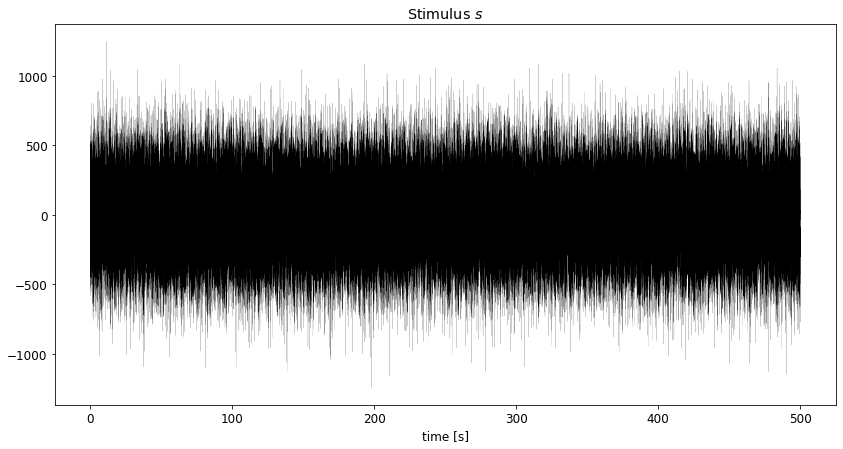

In [3]:
T = 500  # trial length [s]
dt = 5 * 0.001  # time step [s]
var = 2  # variance [s]
std_dev = np.sqrt(var)
trial_length = np.linspace(0, T, int(T/dt))  # [ms]
stimulus = np.random.normal(loc=0, scale=std_dev/dt, size=int(T/dt))  
print(np.shape(stimulus), 'size of the stimulus')
plt.plot(trial_length, stimulus, color='k', linewidth=0.1)
plt.title(r'Stimulus $s$')
plt.xlabel('time [s]')
plt.show()

### (b) ) Compute a firing rate $r_{est}$ in response to the white-noise stimulus $s$.

## <font color='black'> $ r_{est}(t) = r_0 + \int_0^{\infty} d\tau D(\tau) s(t-\tau) $

### Use a baseline rate $r_0$ = 150 spikes/s and encoding kernel,

## <font color='black'> $ D(\tau) = -A cos(\frac{2 \pi (\tau - \tau_{cos})}{\sigma_{cos}}) exp (\frac{-\tau}{\sigma_{exp}}) $

### where $A = 200$ spikes/$s^2$ , $τ_{cos} = 20 ms$, $σ_{cos} = 140 ms$, and $σ_{exp} = 60 ms$. Note that $D$ has units of spikes/$s^2$.

In [4]:
def encoding_kernel(tau, tau_cos, sig_cos, sig_exp, A):
    return -A * np.cos((2*np.pi*(tau-tau_cos)/sig_cos)) * np.exp(-tau/sig_exp)

(3000,) size of the encoding kernel


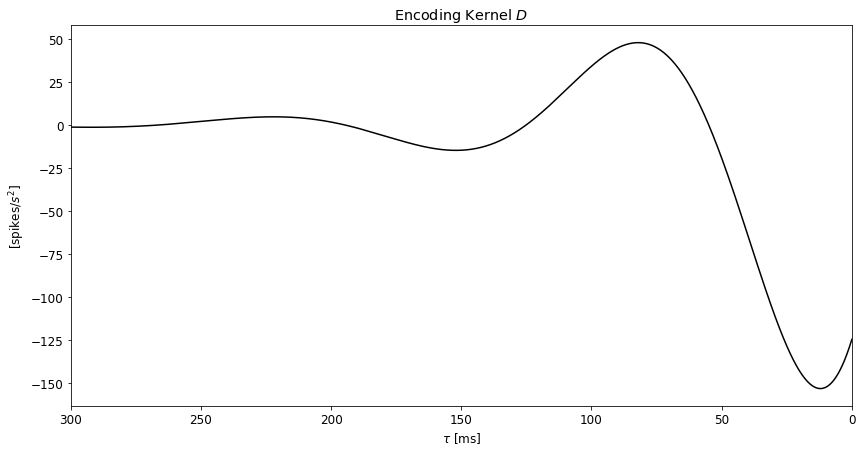

In [5]:
tau_range = np.linspace(0, 300*0.001, 3000)  # [s]
D = encoding_kernel(tau=tau_range, tau_cos=20*0.001, sig_cos=140*0.001, sig_exp=60*0.001, A=200)  # [s]
D_shifted = np.zeros(len(tau_range))
D_shifted[len(tau_range)//2:] = D[:len(tau_range)//2]
print(np.shape(D), 'size of the encoding kernel')
plt.plot(tau_range*1000, D, color='k')
plt.title(r'Encoding Kernel $D$')
plt.ylabel(r'[spikes/$s^2$]')
plt.xlabel(r'$\tau$ [ms]')
plt.xlim(300, 0)
plt.show()

In [6]:
def estimated_firing_rate(kernel, stimulus):  # estimated firing rate
    return np.convolve(kernel, stimulus, mode='same')

(100000,) size of the estimated firing rate


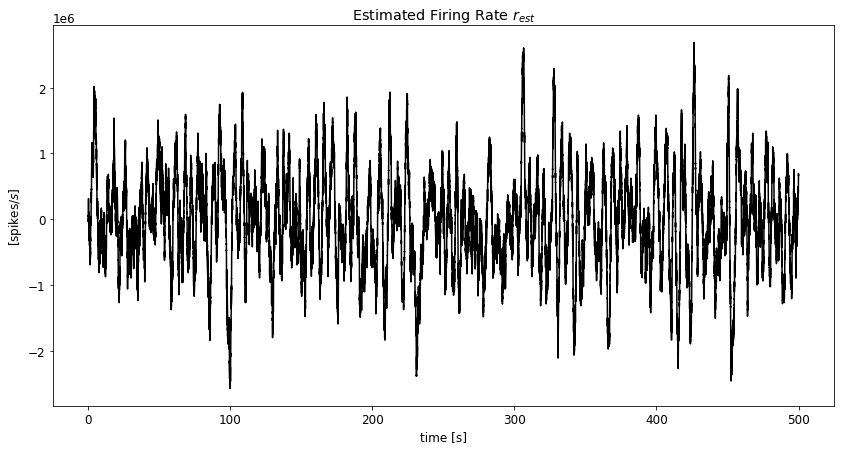

In [7]:
r_0 = 150  # [spikes/s]
r_est = (r_0 + estimated_firing_rate(kernel=D_shifted, stimulus=stimulus))  # [spikes/s]
r_est = r_est[(len(r_est)-len(trial_length)):]  # cut down to trial length size size
print(np.shape(r_est), 'size of the estimated firing rate')
plt.plot(trial_length, r_est, color='k')
plt.title(r'Estimated Firing Rate $r_{est}$')
plt.ylabel(r'[spikes/$s$]')
plt.xlabel('time [s]')
plt.show()

In [8]:
avg_rate = np.mean(r_est)
print(avg_rate, 'average estimated firing rate')

-19858.218870968936 average estimated firing rate


### (c) Compute the autocorrelation of the baseline-corrected response $r_{est}−r_0$. 
### You can use the $numpy$ function $correlate$ and scale the result by $∆t/T$.

In [9]:
def autocorrelation(data):
    return np.correlate(data, data, mode='same')

(100000,) size of the baseline-corrected response autocorrelation


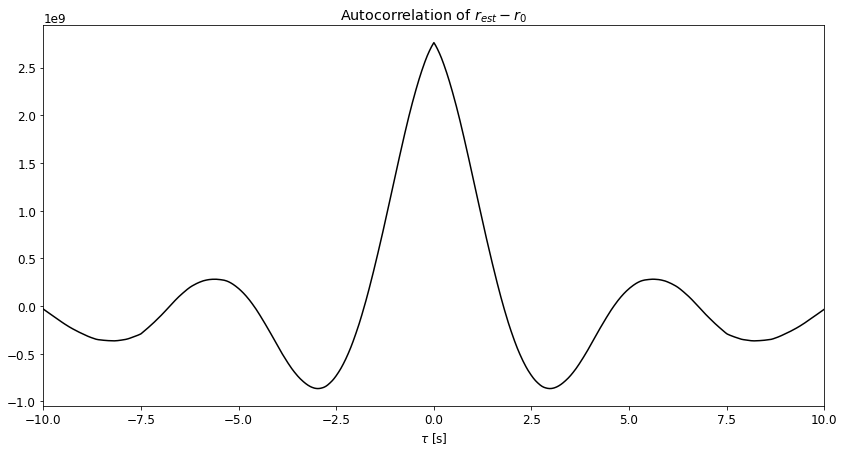

In [10]:
ac_time = trial_length - T/2  # autocorrelation time range
corr_resp_acorrelation = autocorrelation(data=r_est-r_0) * dt/T * dt  # baseline-corrected autocorrelation
#corr_resp_acorrelation[np.argmax(corr_resp_acorrelation)] = 0  # remove the peak
print(np.shape(corr_resp_acorrelation), 'size of the baseline-corrected response autocorrelation')
plt.plot(ac_time, corr_resp_acorrelation, color='black')
plt.title(r'Autocorrelation of $r_{est}-r_0$')
plt.xlabel(r'$\tau$ [s]')
plt.xlim(-10, 10)
plt.show()

### (d) Generate a spike train $ρ$ from an inhomogenous Poisson process with rate $r_{est}(t)$ and compute the spike-train autocorrelation function $Q_{ρρ}$. How does it relate to the autocorrelation of $r_{est}$? 
### Hint: remove the central peak for better comparison. Is the assumption of an uncorrelated neural response valid in this case? (see Equation 3.57 in Dayan and Abbott).

Provided from the previous notebooks, a function to generate a spike train $\rho$ from a firing rate:

In [11]:
def inh_Poisson(rates, trial_time, dt):
    # generate synthetic spike train
    maxRate = np.max(rates)  # rate in spikes per second
    randNums = np.random.uniform(size=len(trial_time/dt))  # random numbers, uniform distribution
    rhoGen = np.zeros(len(trial_time/dt))
    rhoGen[randNums<rates*dt] = 1/dt
    spike_times = np.where(rhoGen)[0] * dt
    return spike_times

(48171,) size of the spike train


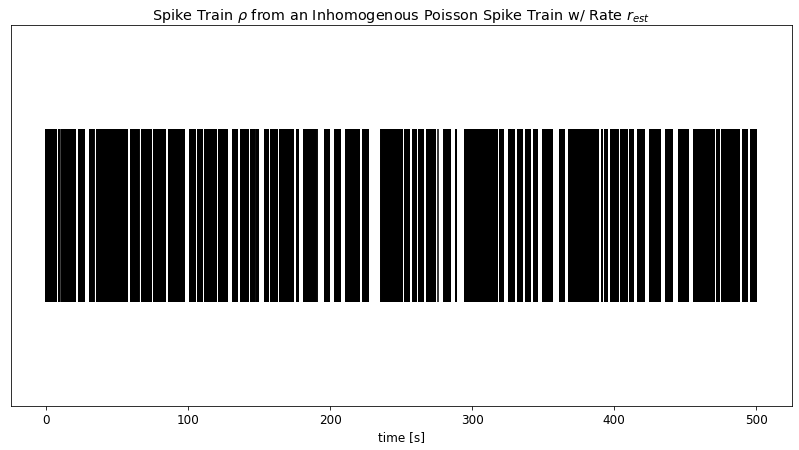

In [12]:
spike_train = inh_Poisson(rates=r_est, trial_time=trial_length, dt=dt)
print(np.shape(spike_train), 'size of the spike train')
plt.eventplot(spike_train, color='black')
plt.title(r'Spike Train $\rho$ from an Inhomogenous Poisson Spike Train w/ Rate $r_{est}$')
plt.xlabel('time [s]')
plt.yticks([])
plt.show()

In [13]:
# change spike times to binary spike points rho
rho = np.histogram(spike_train, bins=int(T/dt))[0]  # ones and zeros

(100000,) size of the spike-train autocorrelation


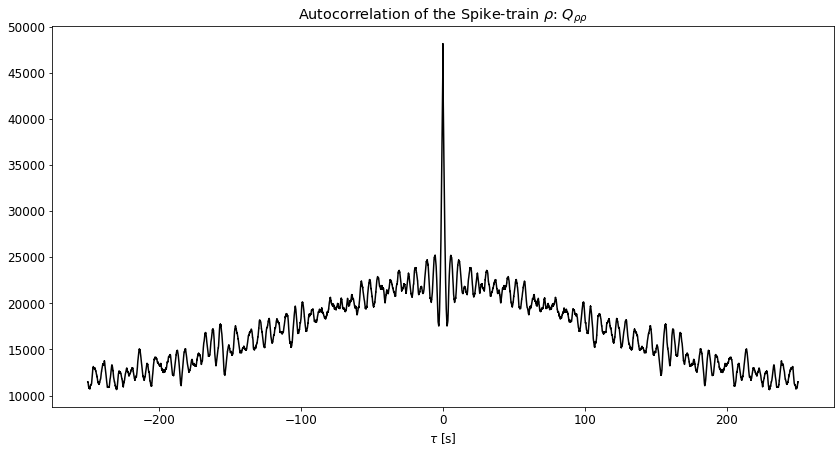

In [14]:
spike_train_acorrelation = autocorrelation(data=rho)  # baseline-corrected autocorrelation
print(np.shape(spike_train_acorrelation), 'size of the spike-train autocorrelation')
plt.plot(ac_time, spike_train_acorrelation, color='black')  # plot for spike train
plt.title(r'Autocorrelation of the Spike-train $\rho$: $Q_{\rho \rho}$')
plt.xlabel(r'$\tau$ [s]')
plt.show()

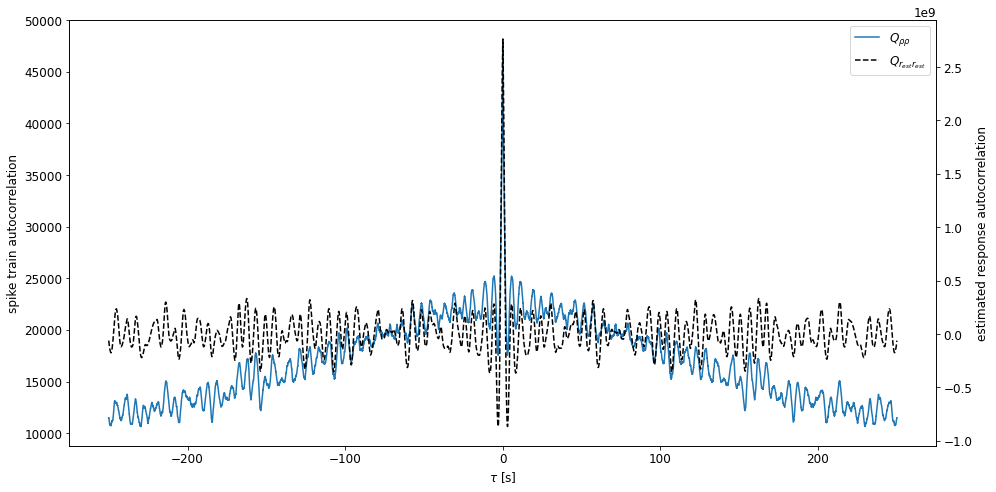

In [15]:
fig = plt.figure()
host = fig.add_subplot(111)
par1 = host.twinx()
p1, = host.plot(ac_time, spike_train_acorrelation, label=r'$Q_{\rho \rho}$')
p2, = par1.plot(ac_time, corr_resp_acorrelation, color='black', linestyle='--', label=r'$Q_{r_{est} r_{est}}$')
host.set_ylabel('spike train autocorrelation')
host.set_xlabel(r'$\tau$ [s]')
par1.set_ylabel('estimated response autocorrelation')
lns = [p1, p2]
host.legend(handles=lns)
fig.tight_layout()
plt.show()

Have roughly the same form, with the autocorrelation of the estimate firing rate staying straight while the rho autocorrelations moves as the magnitude of tau increases.

### (e) Compute the autocorrelation of the encoding filter $D$ and compare it to the autocorrelation of $r_{est}$ and $Q_{ρρ}$. What do you observe?

(3000,) size of the kernel autocorrelation


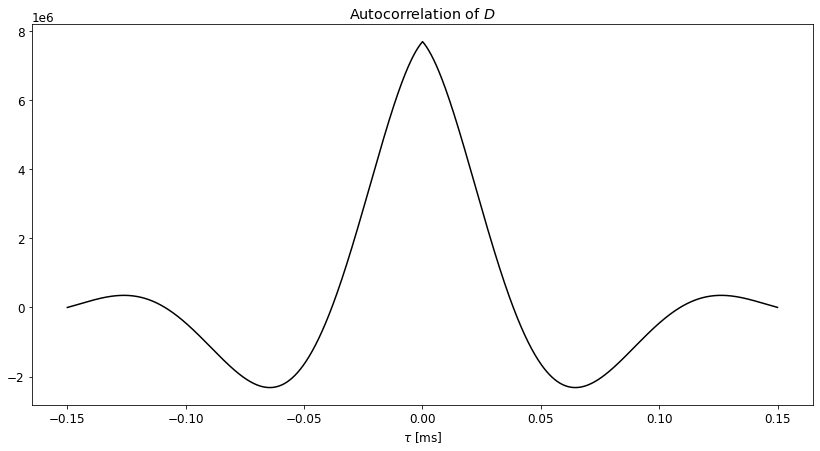

In [16]:
ac_time_tau = tau_range - 300*0.001/2  # autocorrelation time range for tau
kernel_acorrelation = autocorrelation(data=D_shifted)  # D autocorrelation
print(np.shape(kernel_acorrelation), 'size of the kernel autocorrelation')
plt.plot(ac_time_tau, kernel_acorrelation, color='black')
plt.title(r'Autocorrelation of $D$')
plt.xlabel(r'$\tau$ [ms]')
plt.show()

### (f) Compute a stimulus estimate $s_{est}$ and the optimal decoding kernel $K$. To this end, use the function $estimate\_decoder.py$ provided on Moodle. This function takes as inputs the actual stimulus $s$ and the estimated firing rate $r_{est}$ computed in (b). Plot the decoding kernel $K$, the stimulus $s$, and the estimate of the stimulus $s_{est}$. Verify that $s$ and $s_{est}$ are closely related to each other. 
### Note: one could also try to use $ρ$ instead of $r_{est}$ for decoding, but this is less numerically stable.

In [17]:
# the following function outputs: k,k_time,s_est,s_est_time
e_decoder = estimate_decoder(time=trial_length, s=stimulus, r=r_est, dt=dt, nfft=2**12)
print(np.shape(e_decoder), 'size of the estimate decoder')
k = e_decoder[0]
k_time = e_decoder[1]
s_est = e_decoder[2]
s_est_time = e_decoder[3]

(4,) size of the estimate decoder


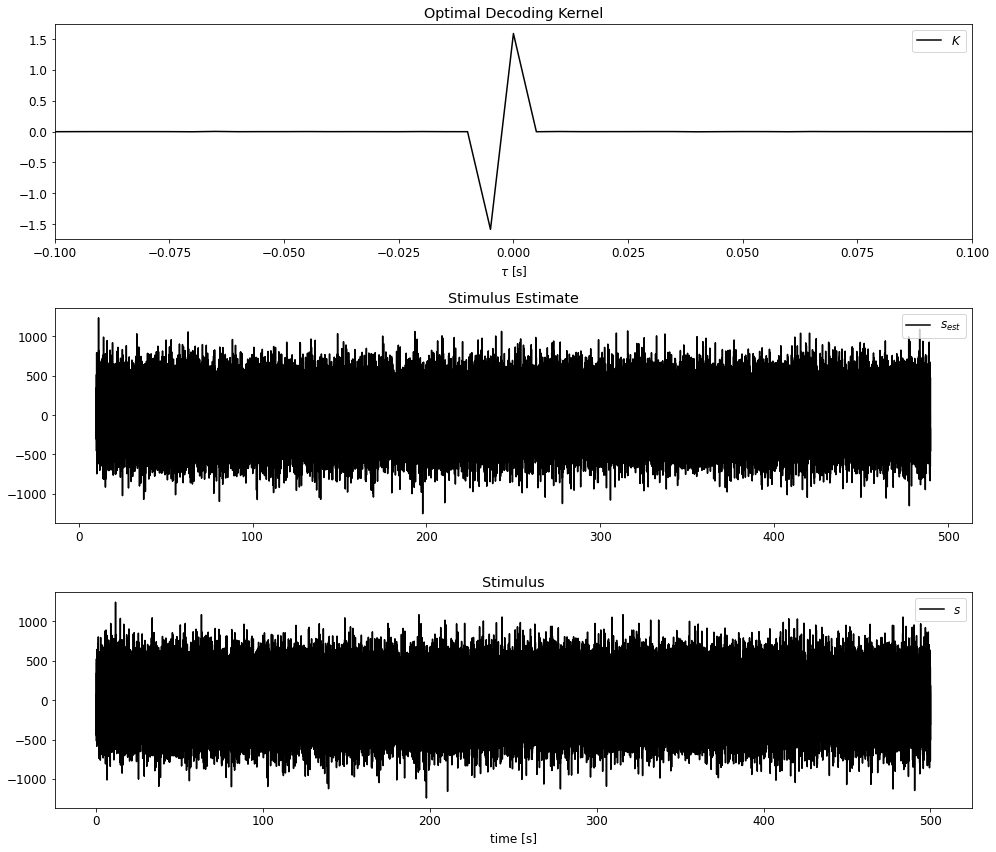

In [18]:
figs, axs = plt.subplots(3, 1, figsize=(14, 12))
axs[0].plot(k_time, k, color='k', label=r'$K$')  # the optimal decoding kernel
axs[0].set_title('Optimal Decoding Kernel')
axs[0].set_xlabel(r'$\tau$ [s]')
axs[0].set_xlim(-0.1, 0.1)
axs[1].plot(s_est_time, s_est, color='k', label=r'$s_{est}$')  # the stimulus estimate
axs[1].set_title('Stimulus Estimate')
axs[2].plot(trial_length, stimulus, color='k', label=r'$s$')
axs[2].set_title('Stimulus')
axs[2].set_xlabel(r'time [s]')
axs[0].legend(loc=1), axs[1].legend(loc=1), axs[2].legend(loc=1)
plt.tight_layout()
plt.show()

(100000,) size of the stimulus correlation


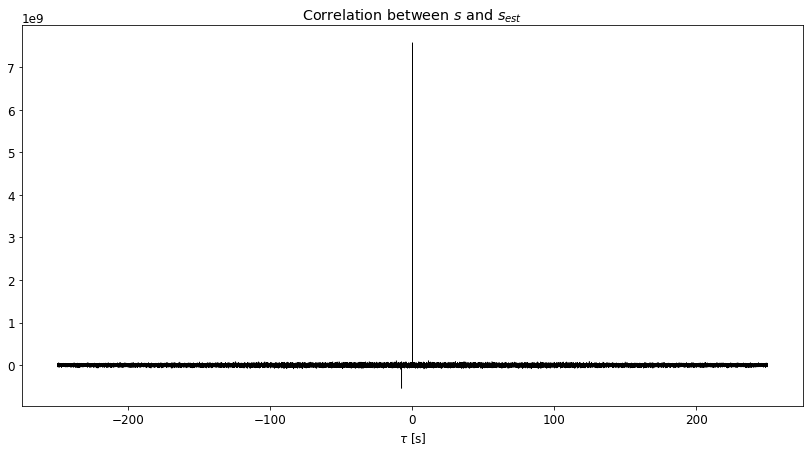

In [19]:
Q_stimulus = np.correlate(stimulus, s_est, mode='same')
print(np.shape(Q_stimulus), 'size of the stimulus correlation')
plt.plot(ac_time, Q_stimulus, color='k', linewidth=0.5)
plt.title(r'Correlation between $s$ and $s_{est}$ ')
plt.xlabel(r'$\tau$ [s]')
plt.show()

From the graphs of the plots of stimulus and estimate stimulus, looks like similar results were achieved.

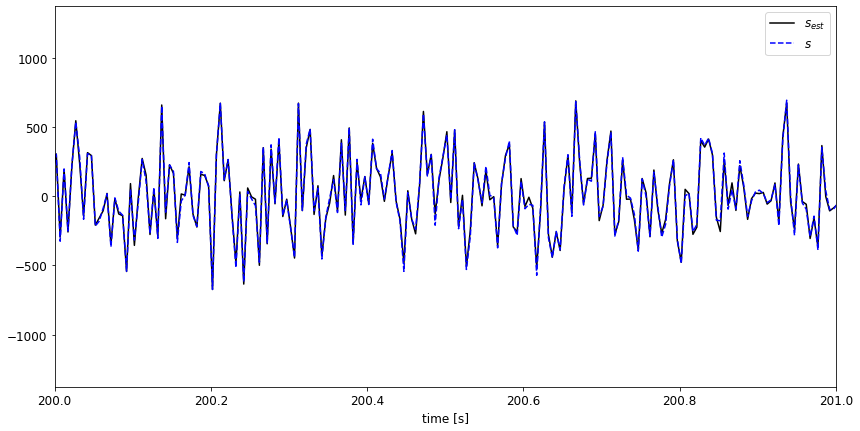

In [20]:
plt.plot(s_est_time, s_est, color='k', label=r'$s_{est}$', linestyle='-') 
plt.plot(trial_length, stimulus, color='b', label=r'$s$', linestyle='--')
plt.xlabel(r'time [s]')
plt.xlim(200, 201)
plt.legend()
plt.show()

### (g) (extra) Describe the relation between the encoding kernel $D$ and the decoding kernel $K$. Hint: think in Fourier domain.

Would be a Fourier transform between the two I believe. 

Encoding acts as the Fourier transform into the frequency domain, while decoding is the transform back with the inverse transform.

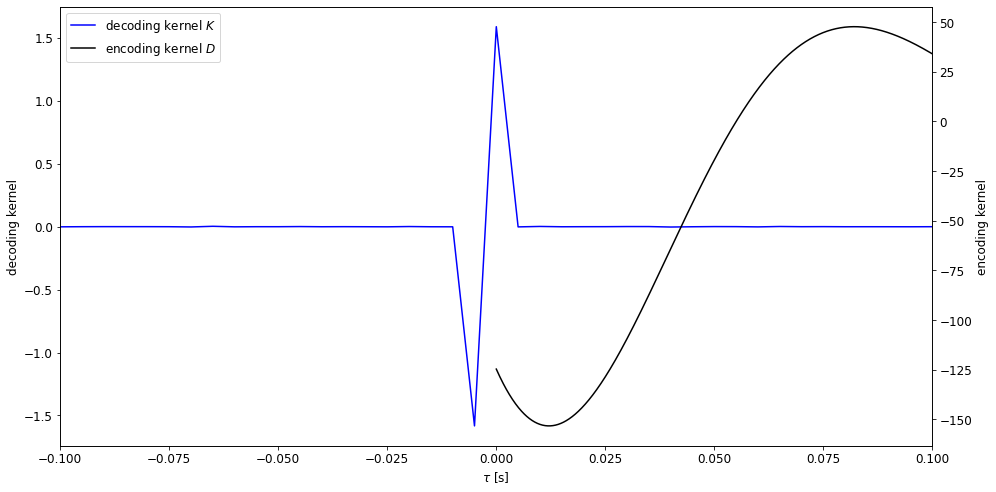

In [21]:
fig = plt.figure()
host = fig.add_subplot(111)
par1 = host.twinx()
p1, = host.plot(k_time, k, color='b', label=r'decoding kernel $K$')
p2, = par1.plot(tau_range, D, color='k', label=r'encoding kernel $D$')
host.set_ylabel('decoding kernel')
par1.set_ylabel('encoding kernel')
host.set_xlabel(r'$\tau$ [s]')
host.set_xlim(0, 0.3)
par1.set_xlim(-0.1, 0.1)
lns = [p1, p2]
host.legend(handles=lns, loc=2)
fig.tight_layout()
plt.show()